In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle
import sys
from utils import utils
import numpy as np
from sklearn.metrics import roc_curve, auc
import math
from sklearn.naive_bayes import GaussianNB

In [ ]:
#g = nx.read_edgelist("data/decoded.tsv")

#print(nx.info(g))
pd.read_csv('data/decoded.tsv', nrows=80, delimiter='\t').to_csv('data/decodedSample.tsv', sep='\t', header = False, index = False)

#reading the edgelist in a variable using networkX
subgraph = nx.read_edgelist('data/decodedSample.tsv', delimiter='\t', create_using=nx.DiGraph())
#plotting the graph
print(nx.info(subgraph))
pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color = '#A0CBE2', edge_color = '#00bb5e', width = 1, edge_cmap = plt.cm.Blues, with_labels = True)
plt.savefig("graph_sample.pdf")

In [ ]:
def generate_missing_edges(out_file, train_percent = 0.7):
    test_percent = 1 - train_percent
    r = pd.read_csv('data/decoded.tsv', delimiter = '\t', header = None)
    nrows = r.shape[0]
    removable_edges = random.sample(range(nrows), int(nrows*test_percent))    
    temp = r
    temp = temp.drop(removable_edges)
    csv = temp.to_csv('data/smaller_edgelist.tsv', sep='\t', index=False, index_label=False)
    pickle.dump(removable_edges,open(out_file, 'wb'))


In [ ]:
generate_missing_edges('data/removedEdgesList.pkl')

In [4]:
def random_forest_clf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    # print(clf.fit(X_train, y_train).summary())
    y_pred = clf.predict(X_test)
    fpr,tpr,ths = roc_curve(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    return [clf,acc,"Random Forest Classifier",fpr,tpr,ths]

def knn_clf(X, y, neighs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    clf = KNeighborsClassifier(n_neighbors = neighs)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return [clf,acc,"K-Nearest Neighbors"]

def nb_clf(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return [clf,acc,"Naive Bayes"]

In [5]:
X = []
with open('data/X_data.pkl', 'rb') as f:
    X = pickle.load(f)
y = []
with open('data/Y_data.pkl', 'rb') as f:
    y = pickle.load(f)

In [6]:
classifiers = []

classifiers.append(random_forest_clf(X,y))
classifiers.append(knn_clf(X,y,int(math.sqrt(len(X)))))
classifiers.append(nb_clf(X,y))

In [7]:
for i in range(len(classifiers)):
    print(classifiers[i][1])

0.971272768872901
0.7794231673678992
0.7287056221479326


In [ ]:
classifiers[0][3:6]

In [9]:
rm_edges = []
with open('data/removedEdgesList.pkl', 'rb') as f:
    rm_edges = pickle.load(f)

# Load original network
G = nx.read_edgelist('data/decoded.tsv', delimiter = '\t', create_using=nx.DiGraph())

# Load smaller network
S = nx.read_edgelist('data/smaller_edgelist.tsv', delimiter = '\t', create_using=nx.DiGraph())

utils.HITS(S, 'data/smaller_hits.pkl')
utils.PR_file(S, 'data/smaller_pr.pkl')

pr = []
with open('data/smaller_pr.pkl', 'rb') as f:
    pr = pickle.load(f)

hits = []
with open('data/smaller_hits.pkl', 'rb') as f:
    hits = pickle.load(f)

cat_dict = []
with open('data/getCategoryFromLinkDict.pkl', 'rb') as f:
    cat_dict = pickle.load(f)

In [11]:
vecs = []
scores = []
for e in G.edges():
    u, v = e
    a = list(utils.create_X(S,u,v, cat_dict,pr,hits))
    vec = np.array(a)
    vecs.append(vec)

for i in range(len(classifiers)):
    y_pred = classifiers[i][0].predict(vecs)
    score = accuracy_score(np.ones(len(G.edges)), y_pred)
    scores.append(score)

print(scores)

[0.94544635558299, 0.6104669591765236, 0.4055487896431491]


In [38]:
print("Example X vector \n")
print(vecs[50])
print(['Number of common categories', 'Jaccard Distance', 'Adamic/Adar Index', 'Page rank for source',
           'Page rank for target', 'HITS for source', 'HITS for target'])

Example X vector 

[2.00000000e+00 5.55555556e-02 6.74533609e-01 1.02068712e-04
 6.57470185e-04 5.99406214e-05 5.46303727e-04]
['Number of common categories', 'Jaccard Distance', 'Adamic/Adar Index', 'Page rank for source', 'Page rank for target', 'HITS for source', 'HITS for target']


For Random Forest Classifier
Variable: hits_y               Importance: 0.26
Variable: pr_y                 Importance: 0.22
Variable: aa                   Importance: 0.2
Variable: jd                   Importance: 0.18
Variable: hits_x               Importance: 0.06
Variable: no_comm              Importance: 0.04
Variable: pr_x                 Importance: 0.04




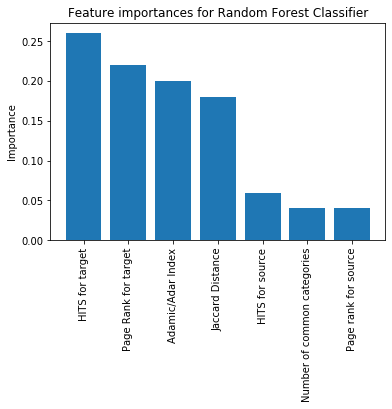

In [34]:
# Calculate feature importances

for i in range(1):
    print("For", classifiers[i][2])
    feature_importances = list(classifiers[i][0].feature_importances_)
    feature_list = list(["no_comm", "jd", "aa", "pr_x", "pr_y", "hits_x", "hits_y"])
    f_importances = [(feature, round(feature_importance, 2)) for feature, feature_importance in zip(feature_list, feature_importances)]
    # Sort the feature importances by most important first
    f_importances = sorted(f_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in f_importances]
    print('\n')
    lab = ['HITS for target', 'Page Rank for target', 'Adamic/Adar Index', 'Jaccard Distance',
           'HITS for source', 'Number of common categories', 'Page rank for source']
    imp = []
    for f in f_importances:
        imp.append(f[1])
    plt.bar(lab,imp)
    plt.ylabel('Importance')
    plt.xticks(lab, rotation='vertical')
    plt.title('Feature importances for Random Forest Classifier')

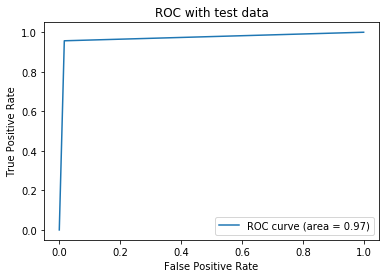

In [13]:
# ROC curve for Random Forest
fpr,tpr,ths = classifiers[0][3:6]
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with test data')
plt.legend()
plt.show()

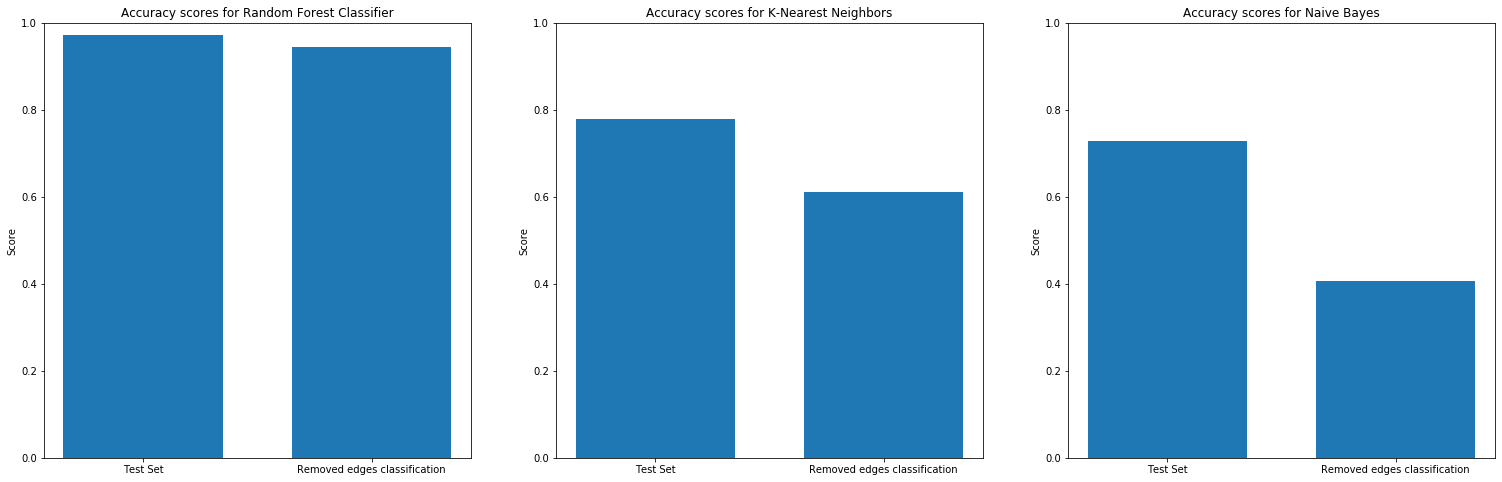

In [23]:
fig, ax = plt.subplots(1,len(classifiers), figsize=(26, 8))
fig.subplots_adjust(hspace=0.5)
i=0
labels =['Test Set', 'Removed edges classification']

for clf in classifiers:
    
    x = np.arange(len(labels))  # the label locations
    width = 0.70  # the width of the bars

    bars = ax[i].bar(x, [clf[1],scores[i]], width)

    ax[i].set_ylabel('Score')
    ax[i].set_ylim([0,1])
    ax[i].set_title('Accuracy scores for ' + str(clf[2]))
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    i = i+1
    
plt.draw()
plt.savefig('pictures/accuracyGraph.png')